<a href="https://colab.research.google.com/github/ancientpi3/Fellowship2022/blob/main/MNIST_GAN_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 [==============================] - 0s 0us/step


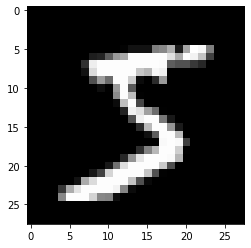

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
plt.imshow(x_train[0], cmap="gray")
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
def discriminator():
  discriminator_input = keras.Input(shape=(28,28,1),name="d_input")
  x = keras.layers.Conv2D(64,(3,3),strides = (2,2),padding = "same", activation="relu")(discriminator_input)
  x = keras.layers.Flatten()(x)
  discriminator_output = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(discriminator_input, discriminator_output,name="discriminator")
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
d_model = discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 1)                 12545     
                                                                 
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def generator(latent_dim=100):
  generator_input = keras.Input(shape=(latent_dim),name="g_input")
  n_nodes = 7*7*128
  x = keras.layers.Dense(n_nodes)(generator_input)
  x = keras.layers.Reshape((7,7,128))(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  x = keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',activation="relu")(x)
  generator_output = keras.layers.Conv2D(1,(7,7),padding="same",activation="sigmoid")(x)
  return keras.Model(generator_input, generator_output,name="generator")


In [ ]:
g_model = generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 g_input (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         62

In [ ]:
def GAN(d_model,g_model):
	d_model.trainable = False
	model = keras.models.Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:
gan_model = GAN(d_model,g_model)
gan_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 28, 28, 1)         934913    
                                                                 
 discriminator (Functional)  (None, 1)                 13185     
                                                                 
Total params: 948,098
Trainable params: 934,913
Non-trainable params: 13,185
_________________________________________________________________


In [ ]:
def grab_real_batch(x_train, batch_size):
	ix = np.random.randint(0, x_train.shape[0], batch_size)
	X = x_train[ix]
	#y = np.ones((batch_size, 1))
	return X

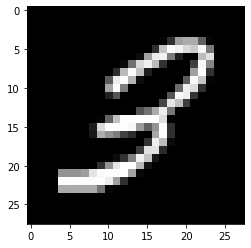

In [ ]:
k = grab_real_batch(x_train,10)
plt.imshow(k[0].reshape(28,28), cmap="gray")

In [ ]:
def grab_fake_batch(g_model,batch_size, latent_dim=100):
  latent_points = np.random.randn(100*batch_size).reshape(batch_size,latent_dim)
  predictions = g_model.predict(latent_points,verbose=0)
  return predictions

In [ ]:
k = grab_fake_batch(g_model,10)

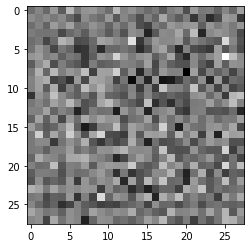

In [ ]:
plt.imshow(k[0].reshape(28,28), cmap="gray")

In [ ]:
def train(d_model,g_model,gan_model, x_train, epochs=200, verbose=1):
  latent_dim = 100
  batch_size = 256
  batches_per_epoch = 50
  for epoch in range(epochs):
    print("Epoch: ",epoch)
    for _ in range(batches_per_epoch):
      d_model.trainable = True
      print("training discriminator on real batch")
      real_batch = grab_real_batch(x_train, batch_size)
      d_model.fit(x=real_batch, y = np.ones(batch_size),verbose=verbose)
      #print("training discriminator on fake batch")
      fake_batch = grab_fake_batch(g_model, batch_size)
      d_model.fit(x=fake_batch, y = np.zeros(batch_size),verbose=verbose)

      d_model.trainable = False
      #print("training GAN on fake batch with real label to measure how well G fools D")
      latent_points = np.random.randn(100*batch_size).reshape(batch_size,latent_dim)
      gan_model.fit(x=latent_points, y=np.ones(batch_size),verbose=verbose)



In [ ]:
train(d_model,g_model,gan_model,x_train,verbose=0)

In [ ]:
results = grab_fake_batch(g_model,5)
plt.imshow(results[3].reshape(28,28), cmap="gray")

In [ ]:
g_model.save("mnist_g_model.h5")

In [ ]:
g_model.load_weights('/content/mnist_g_model.h5')

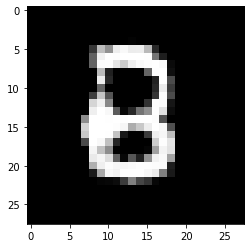

In [ ]:
results = grab_fake_batch(g_model,5)
plt.imshow(results[3].reshape(28,28), cmap="gray")